In [1]:
import os

path='/work/NLP_exam'
os.chdir(path)

# Make the activate.sh file executable
!chmod +x activate.sh

# Now run the script
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


## Importing packages

In [10]:
import gensim
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt

## Defining categories of words

In [9]:
positive_agency = ["influence", "power", "authority", "control", "leadership", "mastery", "dominion", "sovereignty", "creator", "command", "dominance", "lead", "dominate", "command", "create", "initiate", 
    "direct", "rule", "guide", "shape", "inspire", "enforce", 
    "independent", "powerful", "dominant", "influential","authoritative", "sovereign", "commanding", "masterful"]

negative_agency = ["victim", "follower", "subordinate", "dependent", "object", "servant", "puppet", "oppressed", 
    "captive", "helpless", "weakness", "suffer", "submit", "endure", "yield", "depend", "obey", "serve", "succumb", "resist", "conform", 
    "bow", "powerless", "helpless", "dependent", "submissive", "weak", "controlled", "defenseless", "subordinate", "resigned", 
    "passive"]

high_competence = ["intelligent", "successful", "confident", "skilled", "expert", "proficient", "competent", 
    "capable", "brilliant", "accomplished", "talented", "resourceful", 
    "experienced", "sharp", "masterful", "ingenious", "brilliant", "outstanding", 
    "accomplished", "efficient", "specialized", "ingenious", "elite", "excel", "master", "achieve", "succeed", "surpass",
    "excelled", "advanced", "gifted", "exceptional", "dynamic"]

low_competence = ["incompetent", "unskilled", "ignorant", "unqualified", "incapable", "unfit", 
    "untrained", "inefficient", "unaware", "amateur", "clumsy", "mediocre", "unprofessional", "failure", "inexperienced", "incapable", "deficient", 
    "awkward", "slow", "dull", "fail", "lack", "helpless", "unfit", "ineffective", "inadequate", "unsuccessful", "weak", "unreliable", "poor", "insufficient"]

high_warmth = ["considerate", "caring", "compassionate", "kind", "affectionate", "loving", 
    "understanding", "generous", "thoughtful", "tender", 
    "sympathetic", "friendly", "gentle", "patient", "helpful", "altruistic", "encouraging", 
    "devoted", "gracious", "humane", "concerned", "giving", "respectful", 
    "charitable", "sensitive", "compassionate", "receptive", "welcoming", "caring"]

low_warmth = ["cold", "cynical", "apathetic", "indifferent", "aloof", "distant", "hostile", "unfeeling", 
    "callous", "detached", "unconcerned", "unfriendly", 
    "harsh", "unemotional", "unsympathetic", "unresponsive", "disinterested", "ruthless", 
    "hateful", "dispassionate", "unkind", "cruel", "indifferent", "ungracious", "unresponsive", "emotionless", "heartless", "selfish"]

# All categories combined
all_categories = {
    "positive_agency": positive_agency,
    "negative_agency": negative_agency,
    "high_competence": high_competence,
    "low_competence": low_competence,
    "high_warmth": high_warmth,
    "low_warmth": low_warmth
}

# Calculate the total number of words in all categories
total_words = sum(len(target_words) for target_words in all_categories.values())

print(f"Total number of words in all categories: {total_words}")


Total number of words in all categories: 183


## Calculate similarity + gender bias for each word and put it in a dataframe

In [8]:
he_word = "he"
she_word = "she"

# Folder path where models are stored
models_folder = '/work/NLP_exam/he_she_aligned_models'

# Function to load all Word2Vec models in the folder
def load_models_from_folder(folder_path):
    models = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".w2v"):  # Adjust file extension if needed
            model_path = os.path.join(folder_path, filename)
            model = Word2Vec.load(model_path)
            models[filename] = model.wv  # Use filename as the key (no year extraction needed)
    return models

# Function to calculate the cosine similarity using gensim's similarity method
def calculate_similarity(word_vectors, word1, word2):
    if word1 in word_vectors and word2 in word_vectors:
        return word_vectors.similarity(word1, word2)
    else:
        return None  # Return None if any word is missing

# Load all models
models = load_models_from_folder(models_folder)

# Prepare a list to collect results
results = []

# Check similarity for each model and word
for model_name, word_vectors in models.items():
    # Extract the year directly from the model name (before the file extension)
    year = model_name.replace('.w2v', '')  # Assuming the model name is like '1900.w2v'

    for category_name, target_words in all_categories.items():
        for target_word in target_words:
            # Calculate similarity with "he" and "she"
            similarity_he = calculate_similarity(word_vectors, target_word, "he")
            similarity_she = calculate_similarity(word_vectors, target_word, "she")
            
            if similarity_he is not None and similarity_she is not None:
                gender_bias = similarity_he - similarity_she  # Gender bias as the difference
                # Append the results to the list
                results.append({
                    "year": year,
                    "category": category_name,
                    "word": target_word,
                    "similarity_with_he": similarity_he,
                    "similarity_with_she": similarity_she,
                    "gender_bias": gender_bias
                })

# Convert results into a pandas DataFrame
df = pd.DataFrame(results)

# Print the resulting DataFrame (for checking)
print(df)
#save the results to a CSV file
#df.to_csv("word_similarity_results.csv", index=False)

       year         category          word  similarity_with_he  \
0      1969  positive_agency     influence            0.446890   
1      1969  positive_agency         power            0.357855   
2      1969  positive_agency     authority            0.434154   
3      1969  positive_agency       control            0.357907   
4      1969  positive_agency    leadership            0.549100   
...     ...              ...           ...                 ...   
18295  1978       low_warmth    ungracious            0.685225   
18296  1978       low_warmth  unresponsive            0.635143   
18297  1978       low_warmth   emotionless            0.675452   
18298  1978       low_warmth     heartless            0.651092   
18299  1978       low_warmth       selfish            0.523856   

       similarity_with_she  gender_bias  
0                 0.433605     0.013285  
1                 0.284253     0.073602  
2                 0.390482     0.043672  
3                 0.306923     0.050985

## Investigate gender bias for a word over time

In [12]:
# Function to plot gender bias for a given word
def plot_gender_bias_over_time(df, target_word):
    # Filter the DataFrame for the given word
    df_word = df[df['word'] == target_word]
    
    # Ensure the DataFrame is sorted by year
    df_word["year"] = pd.to_numeric(df_word["year"])
    df_word = df_word.sort_values("year")
    
    # Plot the gender bias over time
    plt.figure(figsize=(10, 6))
    plt.plot(df_word["year"], df_word["gender_bias"], marker='o', linestyle='-', color='b')
    plt.title(f"Development of Gender Bias Over Time for '{target_word}'")
    plt.xlabel("Year")
    plt.ylabel("Gender Bias (Similarity with 'he' - 'she')")
    plt.grid(True)
    plt.show()


/tmp/ipykernel_2080/1219138165.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_word["year"] = pd.to_numeric(df_word["year"])


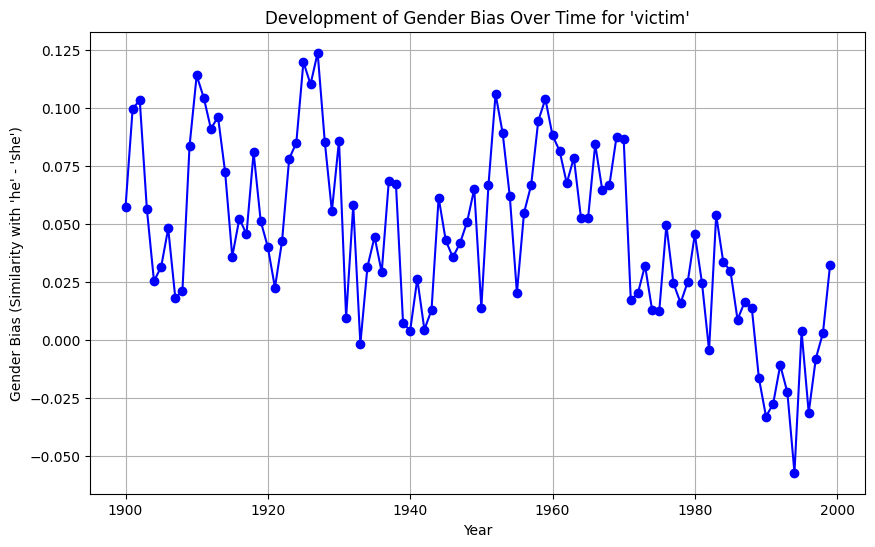

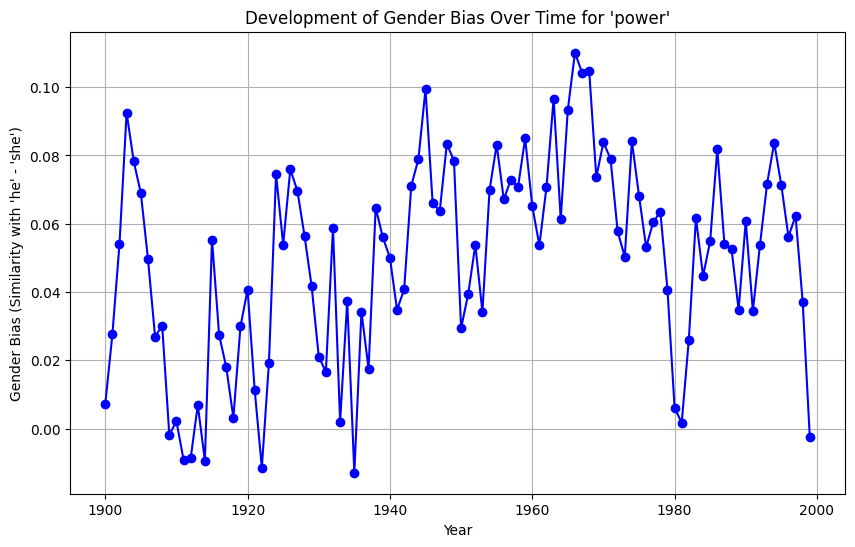

In [13]:
# Plot gender bias for the word 'victim'
plot_gender_bias_over_time(df, 'victim')

# Plot gender bias for any other word, e.g., 'power'
plot_gender_bias_over_time(df, 'power')

## Investigate gender bias for category over time

In [28]:
# Function to plot average gender bias over time for a given category
def plot_average_gender_bias_by_category(df, category_words, category_name):
    # Filter the DataFrame for the given category words
    df_category = df[df['word'].isin(category_words)]
    
    # Group by year and calculate the average gender bias for each year
    df_category_avg = df_category.groupby("year").agg({"gender_bias": "mean"}).reset_index()
    
    # Ensure the DataFrame is sorted by year
    df_category_avg["year"] = pd.to_numeric(df_category_avg["year"])
    df_category_avg = df_category_avg.sort_values("year")
    
    # Plot the average gender bias over time
    plt.figure(figsize=(10, 6))
    plt.plot(df_category_avg["year"], df_category_avg["gender_bias"], marker='o', linestyle='-', color='g')
    plt.title(f"Average Development of Gender Bias Over Time for Category: {category_name}")
    plt.xlabel("Year")
    plt.ylabel("Average Gender Bias (Similarity with 'he' - 'she')")
    plt.grid(True)
    plt.show()

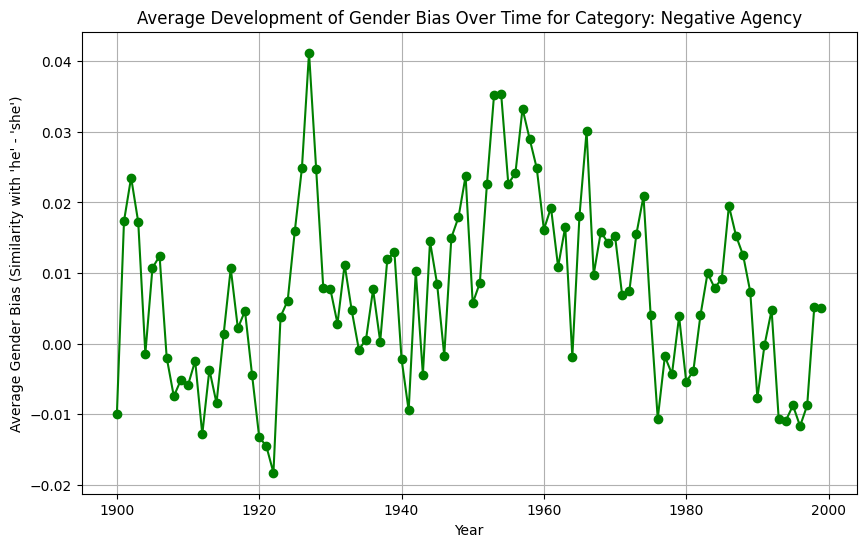

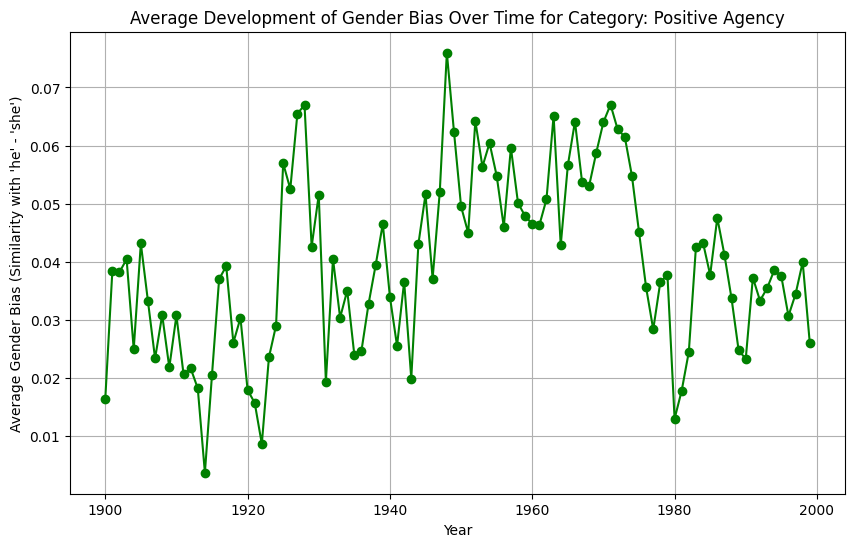

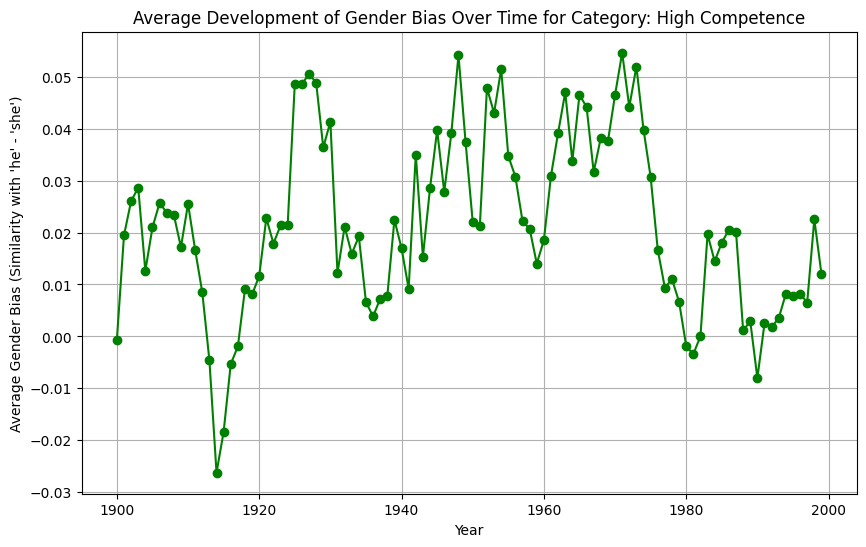

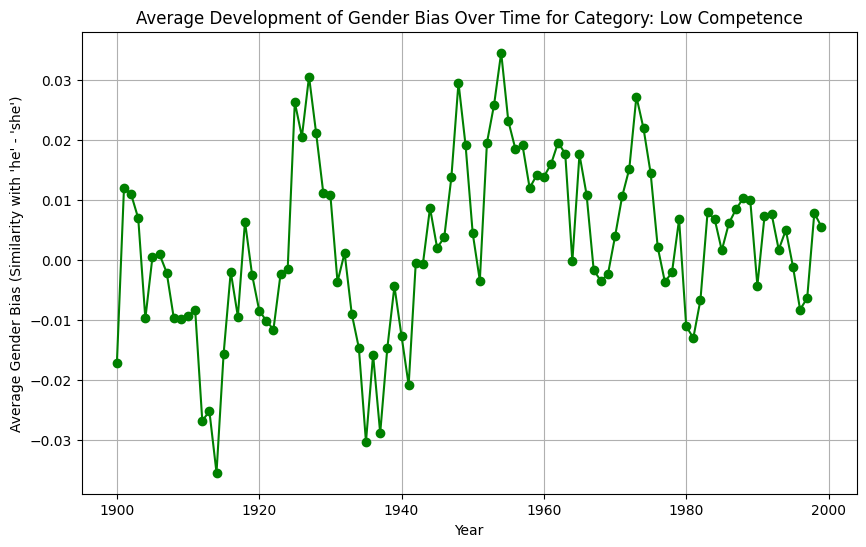

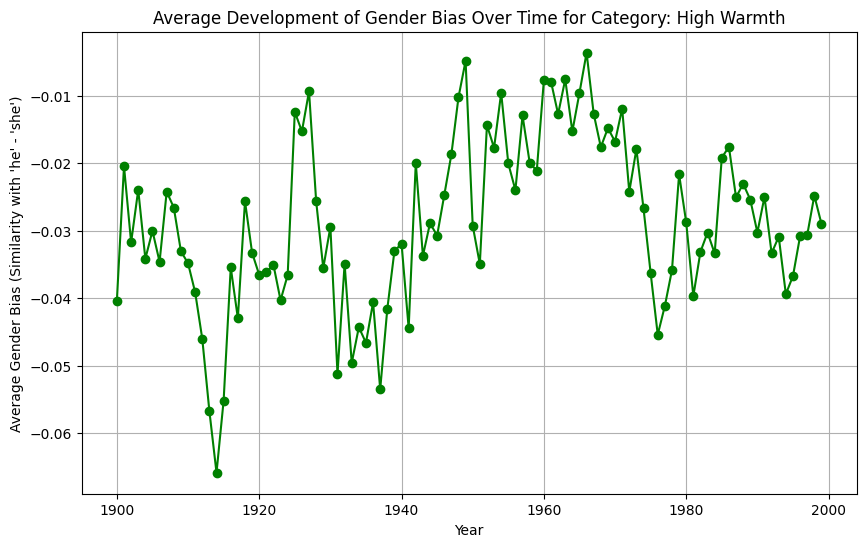

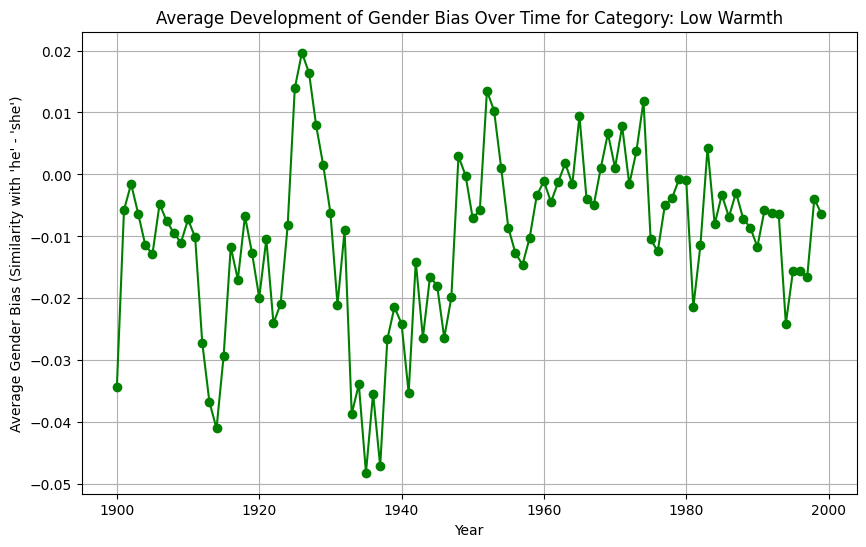

In [29]:
plot_average_gender_bias_by_category(df, negative_agency, "Negative Agency")
plot_average_gender_bias_by_category(df, positive_agency, "Positive Agency")
plot_average_gender_bias_by_category(df, high_competence, "High Competence")
plot_average_gender_bias_by_category(df, low_competence, "Low Competence")
plot_average_gender_bias_by_category(df, high_warmth, "High Warmth")
plot_average_gender_bias_by_category(df, low_warmth, "Low Warmth")